Mass inference
------------------

The ASE calculator is not necessarily the most efficient way to run a lot of computations. It is better to do a "mass inference" using a command line utility. We illustrate how to do that here. 

In this paper we computed about 10K different gold structures:

Boes, J. R., Groenenboom, M. C., Keith, J. A., & Kitchin, J. R. (2016). Neural network and Reaxff comparison for Au properties. Int. J. Quantum Chem., 116(13), 979–987. http://dx.doi.org/10.1002/qua.25115

You can retrieve the dataset below. In this notebook we learn how to do "mass inference" without an ASE calculator. You do this by creating a config.yml file, and running the `main.py` command line utility.

In [1]:
! [ ! -f data.db ]  && wget https://figshare.com/ndownloader/files/11948267 -O data.db 

In [2]:
! ase db data.db

id|age|user |formula|calculator|  energy|natoms| fmax|pbc|  volume|charge|     mass
 1| 9y|jboes|Au55   |vasp      |-170.717|    55|0.164|TTT|3304.114| 0.000|10833.161
 2| 9y|jboes|Au55   |vasp      |-170.717|    55|0.165|TTT|3304.114| 0.000|10833.161
 3| 9y|jboes|Au55   |vasp      |-170.718|    55|0.167|TTT|3304.114| 0.000|10833.161
 4| 9y|jboes|Au55   |vasp      |-170.721|    55|0.170|TTT|3304.114| 0.000|10833.161
 5| 9y|jboes|Au55   |vasp      |-170.732|    55|0.207|TTT|3304.114| 0.000|10833.161
 6| 9y|jboes|Au55   |vasp      |-170.762|    55|0.310|TTT|3304.114| 0.000|10833.161
 7| 9y|jboes|Au55   |vasp      |-170.816|    55|0.507|TTT|3304.114| 0.000|10833.161
 8| 9y|jboes|Au55   |vasp      |-170.905|    55|0.664|TTT|3304.114| 0.000|10833.161
 9| 9y|jboes|Au55   |vasp      |-171.034|    55|0.640|TTT|3304.114| 0.000|10833.161
10| 9y|jboes|Au55   |vasp      |-171.149|    55|0.522|TTT|3304.114| 0.000|10833.161
11| 9y|jboes|Au55   |vasp      |-171.270|    55|0.177|TTT|3304.114| 0.000|10

You have to choose a checkpoint to start with. The newer checkpoints may require too much memory for this environment. 

In [3]:
%run ../ocp-tutorial.ipynb
list_checkpoints()

See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.
CGCNN 200k
CGCNN 2M
CGCNN 20M
CGCNN All
DimeNet 200k
DimeNet 2M
SchNet 200k
SchNet 2M
SchNet 20M
SchNet All
DimeNet++ 200k
DimeNet++ 2M
DimeNet++ 20M
DimeNet++ All
SpinConv 2M
SpinConv All
GemNet-dT 2M
GemNet-dT All
PaiNN All
GemNet-OC 2M
GemNet-OC All
GemNet-OC All+MD
GemNet-OC-Large All+MD
SCN 2M
SCN-t4-b2 2M
SCN All+MD
eSCN-L4-M2-Lay12 2M
eSCN-L6-M2-Lay12 2M
eSCN-L6-M2-Lay12 All+MD
eSCN-L6-M3-Lay20 All+MD
EquiformerV2 (83M) 2M
EquiformerV2 (31M) All+MD
EquiformerV2 (153M) All+MD
GemNet-dT OC22
GemNet-OC OC22
GemNet-OC OC20+OC22
GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22
GemNet-OC OC20->OC22
Copy one of these keys to get_checkpoint(key) to download it.


In [4]:
checkpoint = get_checkpoint('GemNet-dT OC22')
checkpoint

'gndt_oc22_all_s2ef.pt'

We have to update our configuration yml file with the dataset. It is necessary to specify the train and test set for some reason. 

In [5]:
yml = generate_yml_config(checkpoint, 'config.yml',
                   delete=['cmd', 'logger', 'task', 'model_attributes',
                           'dataset', 'slurm'],
                   update={'amp': True,
                           'gpus': 1,
                           'task.dataset': 'ase_db',
                           'task.prediction_dtype': 'float32',
                        
                           # Train data
                           'dataset.train.src': 'data.db',
                           'dataset.train.a2g_args.r_energy': False,
                           'dataset.train.a2g_args.r_forces': False,
                           'dataset.train.select_args.selection': 'natoms>5,xc=PBE',
                            # Test data - prediction only so no regression
                           'dataset.test.src': 'data.db',
                           'dataset.test.a2g_args.r_energy': False,
                           'dataset.test.a2g_args.r_forces': False,
                           'dataset.test.select_args.selection': 'natoms>5,xc=PBE',
                          })

yml

PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/advanced/config.yml')

It is a good idea to redirect the output to a file. If the output gets too large here, the notebook may fail to save. Normally I would use a redirect like `2&>1`, but this does not work with the main.py method. An alternative here is to open a terminal and run it there.

In [6]:
%%capture inference
import time
t0 = time.time()
! python {ocp_main()} --mode predict --config-yml {yml} --checkpoint {checkpoint} --amp
print(f'Elapsed time = {time.time() - t0:1.1f} seconds')

In [7]:
! grep "Total time taken:" 'mass-inference.txt'

In [8]:
with open('mass-inference.txt', 'wb') as f:
    f.write(inference.stdout.encode('utf-8')) 

The mass inference approach takes 1-2 minutes to run. See the output [here](./mass-inference.txt).

In [9]:
results = ! grep "  results_dir:" mass-inference.txt
d = results[0].split(':')[-1].strip()

In [10]:
import numpy as np
results = np.load(f'{d}/s2ef_predictions.npz', allow_pickle=True)
results.files

['ids', 'energy', 'forces', 'chunk_idx']

It is not obvious, but the data from mass inference is not in the same order. We have to get an id from the mass inference, and then "resort" the results so they are in the same order.

In [11]:
inds = np.array([int(r.split('_')[0]) for r in results['ids']])
sind = np.argsort(inds)
inds[sind]

array([   0,    1,    2, ..., 8488, 8489, 8490])

To compare this with the results, we need to get the energy data from the ase db.

In [12]:
from ase.db import connect
db = connect('data.db')

energies = np.array([row.energy for row in db.select('natoms>5,xc=PBE')])
natoms = np.array([row.natoms for row in db.select('natoms>5,xc=PBE')])

Now, we can see the predictions. The are only ok here; that is not surprising, the data set has lots of Au configurations that have never been seen by this model. Fine-tuning would certainly help improve this.

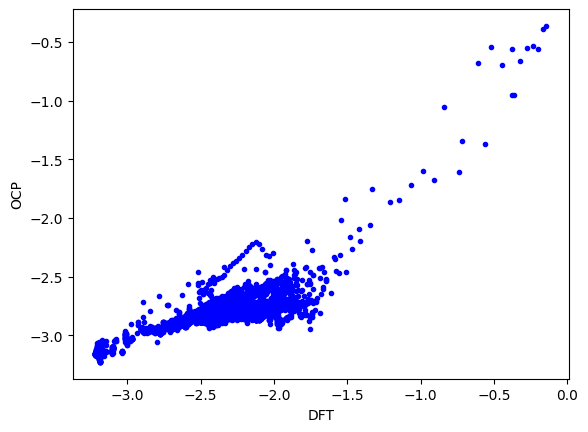

In [13]:
import matplotlib.pyplot as plt

plt.plot(energies / natoms, results['energy'][sind] / natoms, 'b.')
plt.xlabel('DFT')
plt.ylabel('OCP');

# The ASE calculator way

We include this here just to show that:

1. We get the same results
2. That this is much slower.

In [14]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint=os.path.expanduser(checkpoint), cpu=False)

amp: true
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/advanced/checkpoints/2023-07-30-18-01-36
  commit: 3973c79
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/advanced/logs/tensorboard/2023-07-30-18-01-36
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/advanced/results/2023-07-30-18-01-36
  seed: null
  timestamp_id: 2023-07-30-18-01-36
dataset: null
gpus: 1
logger: tensorboard
model: gemnet_t
model_attributes:
  activation: silu
  cbf:
    name: spherical_harmonics
  cutoff: 6.0
  direct_forces: true
  emb_size_atom: 512
  emb_size_bil_trip: 64
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_rbf: 16
  emb_size_trip: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  max_neighbors: 50
  num_after_skip: 2
  num_atom: 3
  num_before_skip: 1
  num_blocks: 3
  num_concat: 1
  num_radial: 128
  num_spherical: 7
  otf_graph: true
  output_init: 

In [15]:
import time
from tqdm import tqdm
t0 = time.time()
OCP, DFT = [], []
for row in tqdm(db.select('natoms>5,xc=PBE')):
    atoms = row.toatoms()
    atoms.set_calculator(calc)
    DFT += [row.energy / len(atoms)]
    OCP += [atoms.get_potential_energy() / len(atoms)]
print(f'Elapsed time {time.time() - t0:1.1} seconds')

8491it [14:53,  9.51it/s]

Elapsed time 9e+02 seconds


This takes at least twice as long as the mass-inference approach above. It is conceptually simpler though, and does not require resorting.

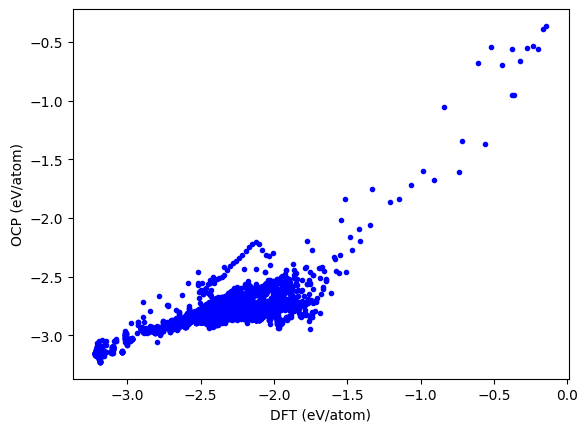

In [16]:
plt.plot(DFT, OCP, 'b.')
plt.xlabel('DFT (eV/atom)')
plt.ylabel('OCP (eV/atom)');

# Comparing ASE calculator and main.py

The results should be the same. 

It is worth noting the default precision of predictions is float16 with main.py, but with the ASE calculator the default precision is float32. Supposedly you can specify `--task.prediction_dtype=float32` at the command line to or specify it in the config.yml like we do above, but as of the tutorial this does not resolve the issue.

As noted above (see also [Issue 542](https://github.com/Open-Catalyst-Project/ocp/issues/542)), the ASE calculator and main.py use different precisions by default, which can lead to small differences. 

In [17]:
np.mean(np.abs(results['energy'][sind] - OCP * natoms))  # MAE

0.047432115622423936

In [18]:
np.min(results['energy'][sind] - OCP * natoms), np.max(results['energy'][sind] - OCP * natoms)

(-2.0, 1.75)

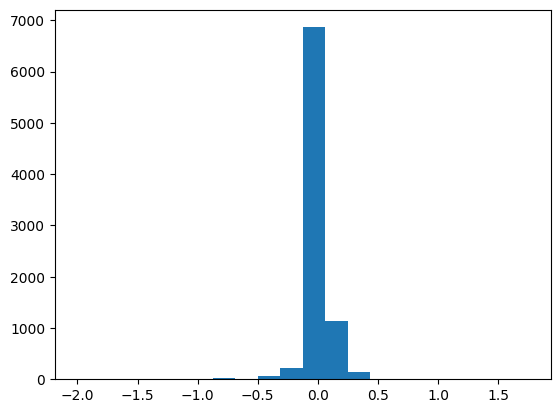

In [19]:
plt.hist(results['energy'][sind] - OCP * natoms, bins=20);

Here we see many of the differences are very small. 0.0078125 = 1 / 128, and these errors strongly suggest some kind of mixed precision is responsible for these differences. It is an open issue to remove them and identify where the cause is.

In [20]:
(results['energy'][sind] - OCP * natoms)[0:400]

array([-0.0078125,  0.       ,  0.       ,  0.       ,  0.       ,
        0.0078125,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.015625 ,  0.       , -0.015625 ,  0.       ,
        0.       ,  0.015625 ,  0.       ,  0.       , -0.015625 ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.015625 ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.015625 ,  0.       ,
       -0.015625 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.    